In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy import stats
import cv2
import pywt

# Load a sample images
flower = cv2.cvtColor(cv2.imread('images/flower.jpg'), cv2.COLOR_BGR2RGB)
veg = cv2.cvtColor(cv2.imread('images/veg.png'), cv2.COLOR_BGR2RGB)
girl= cv2.cvtColor(cv2.imread('images/girl2.png'), cv2.COLOR_BGR2RGB)

# Convert images to Grayscale
flower_img = cv2.cvtColor(flower, cv2.COLOR_RGB2GRAY)
veg_img = cv2.cvtColor(veg, cv2.COLOR_RGB2GRAY)
girl_img = cv2.cvtColor(girl, cv2.COLOR_RGB2GRAY)
   

def show_images(images, titles, images_per_row=3, cmap='gray'):
    """Display a list of images using matplotlib."""
    num_images = len(images)
    num_rows = np.ceil(num_images / images_per_row).astype(int)
    
    # Set the figure size to closely match the manual plot example (15, 5)
    figure_width = 15  # Fixed width
    figure_height = 5 * num_rows  # Adjusted by the number of rows

    plt.figure(figsize=(figure_width, figure_height))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(num_rows, images_per_row, i + 1)
        # If images have different ranges, you might want to set vmin and vmax
        # to the min and max of each image respectively:
        # vmin, vmax = image.min(), image.max()
        # Or, for normalized images, you can omit vmin and vmax to use the default behavior
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Understanding Digital Image Processing

## Image Denoising
### 6.1 Introduction
In the digital age, images and videos are an integral part of our daily communication and media consumption. High-quality visual content is crucial for everything from personal photo sharing to professional publications, making the clarity and visual integrity of images paramount. However, digital images are often susceptible to various forms of noise, which can occur during acquisition, such as when captured by a camera, or throughout processing and transmission. Noise manifests as random visual artifacts that detract from the clarity of the image, often resulting in a grainy appearance that can obscure details and reduce overall quality.

Image denoising is a critical preprocessing step in digital image processing aimed at mitigating the effects of noise. The goal is to reconstruct the original image by estimating it from its noisy observation, thereby preserving the essential features such as edges, textures, and patterns that are vital for interpretation by human viewers or subsequent automated analysis. Effective denoising balances the trade-off between noise removal and the preservation of important image details.

As illustrated a pristine input image $ f(x, y) $ can be corrupted by noise $ n(x, y) $ to give a degraded noisy image $ g(x, y) $. The denoising task seeks to produce a denoised image $ \hat{f}(x, y) $ that is a close representation of the original $ f(x, y) $. The fidelity of the denoised image to the original is largely dependent on the knowledge of the noise characteristics $ n(x, y) $. Understanding these characteristics enables more effective noise suppression techniques.

The subsequent sections will delve into common noise models that affect digital images, outline the attributes of noise, and discuss various established techniques for noise reduction. Through these discussions, we aim to provide insights into the challenges and methodologies of image denoising, setting the stage for deeper exploration into this essential aspect of image processing.

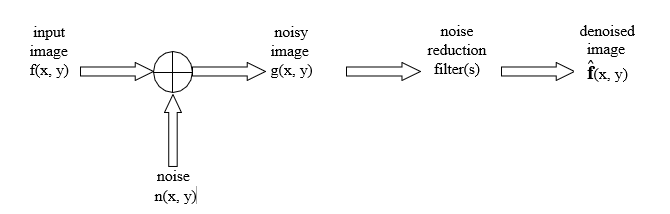

# Understanding Digital Image Processing

## Image Denoising

### 6.2 Image Noise Types

In the realm of digital imaging, noise represents unwanted fluctuations in pixel intensity or color that deviate from the true values in an original scene. It can arise during image capture, due to sensor limitations or environmental conditions, as well as during transmission or storage, often due to electronic interference or data compression errors.

#### 6.2.1 Spatially Independent Noise

Spatially independent noise, also known as uncorrelated noise, is noise that does not depend on the image content or spatial location within the image. It is characterized by its statistical properties, which are uniform throughout the image. Common types of spatially independent noise include:

- **Gaussian Noise:** This is characterized by a normal distribution and is the most common type of noise encountered in imaging systems. It arises due to electronic circuitry noise, sensor noise due to poor illumination, or high temperature.

- **Salt and Pepper Noise (Impulse Noise):** This type of noise presents as random occurrences of black and white (or dark and bright) pixels. It is typically caused by sharp disturbances in the imaging signal, such as analog-to-digital converter errors or bit errors in transmission.

- **Rayleigh Noise:** It is characterized by a Rayleigh distribution and can be caused by the mode of image acquisition. 

- **Gamma (Erlang) Noise:** This noise follows a gamma distribution and can occur in imaging systems where the noise level is proportional to the signal intensity.

- **Exponential Noise:** This follows an exponential distribution and can be encountered in laser imaging systems due to the nature of photon counting statistics.

- **Uniform Noise:** This noise has a constant probability distribution. It is less common in imaging systems but can result from quantization errors.

#### 6.2.2 Spatially Dependent Noise

In contrast, spatially dependent noise is influenced by the image content and varies in different parts of the image. It often has a non-random structure that can be correlated with the image features:

- **Periodic Noise:** Usually caused by electrical or electromechanical interference during the image acquisition process. It often manifests as patterns or "banding" that overlay the image in a regular, repeating manner.

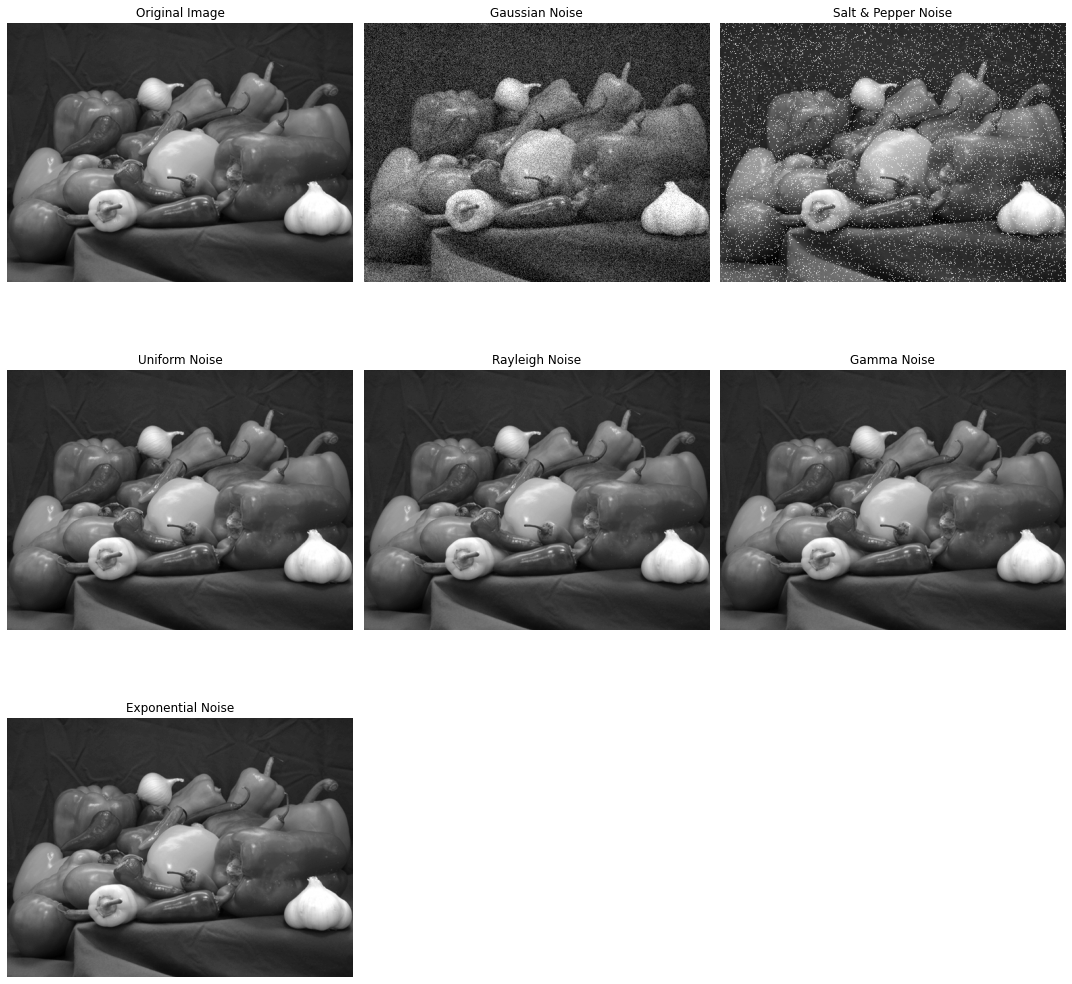

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.util import random_noise

# Load an example image
image = veg_img

# Add Gaussian noise
gaussian_noisy_image = random_noise(veg_img, mode='gaussian', mean=0, var=0.01)

# Add Salt and pepper noise
sp_noisy_image = random_noise(veg_img, mode='salt', amount=0.05)

# Add Rayleigh noise
# For Rayleigh noise, we can use `np.random.rayleigh` and then combine with the image
rayleigh_noise = np.random.rayleigh(scale=0.05, size=veg_img.shape)
rayleigh_noisy_image = image + rayleigh_noise

# Add Gamma noise
# There is no direct function in skimage, so we'll use numpy
gamma_noise = np.random.gamma(shape=1.0, scale=0.05, size=veg_img.shape)
gamma_noisy_image = image + gamma_noise

# Add Exponential noise
exp_noise = np.random.exponential(scale=0.05, size=veg_img.shape)
exp_noisy_image = image + exp_noise

# Add Uniform noise
uniform_noise = np.random.uniform(low=-0.05, high=0.05, size=image.shape)
uniform_noisy_image = image + uniform_noise

# Display the original and noisy images
show_images([veg_img, gaussian_noisy_image, sp_noisy_image, uniform_noisy_image, rayleigh_noisy_image, gamma_noisy_image, exp_noisy_image], 
            ['Original Image', 'Gaussian Noise', 'Salt & Pepper Noise', 'Uniform Noise', 'Rayleigh Noise', 'Gamma Noise', 'Exponential Noise' ], images_per_row=3)